In [60]:
import sys, os
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from IPython.display import Image, display, Markdown

from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage,HumanMessage , SystemMessage
from langgraph.checkpoint.memory import MemorySaver

In [2]:
# Get project root — one level up from 'research_and_analyst'
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

In [3]:
print("Project root added to sys.path:", project_root)

Project root added to sys.path: c:\Users\ARSHPARAM\automated-research-report-generation


In [4]:
from research_and_analyst.utils.model_loader import ModelLoader

In [5]:
model_loader = ModelLoader()

{"timestamp": "2025-12-22T23:40:41.135514Z", "level": "info", "event": "Initializing ApiKeyManager"}
{"timestamp": "2025-12-22T23:40:41.137512Z", "level": "warning", "event": "OPENAI_API_KEY is missing in environment variables"}
{"timestamp": "2025-12-22T23:40:41.141027Z", "level": "info", "event": "GOOGLE_API_KEY loaded successfully from environment"}
{"timestamp": "2025-12-22T23:40:41.143041Z", "level": "info", "event": "GROQ_API_KEY loaded successfully from environment"}
{"path": "C:\\Users\\ARSHPARAM\\automated-research-report-generation\\research_and_analyst\\config\\configuration.yaml", "keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-12-22T23:40:41.148051Z", "level": "info", "event": "Configuration loaded successfully"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-12-22T23:40:41.150051Z", "level": "info", "event": "YAML configuration loaded successfully"}


In [6]:
llm=model_loader.load_llm()

{"provider": "google", "model": "gemini-2.0-flash", "timestamp": "2025-12-22T23:40:41.159793Z", "level": "info", "event": "Loading LLM"}
{"provider": "google", "model": "gemini-2.0-flash", "timestamp": "2025-12-22T23:40:41.249584Z", "level": "info", "event": "LLM loaded successfully"}


In [7]:
llm.invoke("hi").content

'Hi there! How can I help you today?'

In [8]:
def create_analyst(state):
    """Creates an analyst agent with a given state."""
    pass 

In [9]:
def human_feedback(state):
    """AIMessage
    Args:
    state (__type__): description
    """
    pass


In [10]:
def should_continue(state):
    """AIMessage
    Args:
    state (__type__): description
    """
    pass

In [11]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"


In [12]:
analyst = Analyst(
    name="sunny savita",
    role="genai eng",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

In [13]:
print(analyst.persona)

Name: sunny savita
Role: genai eng
Affiliation: AI Research LAB
Description: I am genai developer as well as mentor



In [14]:
class Perspectives(BaseModel):
       analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

In [15]:
class GenerateAnalystsState(TypedDict):
    topic: str #research topic
    max_analysts: int # number of analyst
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

In [16]:
GenerateAnalystsState(
    topic = "finance",
    max_analysts= 5,
    human_analyst_feedback= "give the real info",  
)

{'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'give the real info'}

In [17]:
# %%
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""



In [18]:
# %%
print([analyst_instructions.format(
        topic="education",
        max_analysts=4,
        human_analyst_feedback="please exaplain only on AI"
        
        )] + ["Generate the set of analysts."])


['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']


In [19]:
def create_analyst(state:GenerateAnalystsState):
    """
    it is creating my analyst
    
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
        
        )
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)]+ [HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

In [20]:
create_analyst(
    {'topic': 'health',
    'max_analysts': 2,
    'human_analyst_feedback': 'give the real info'}
    )


{'analysts': [Analyst(name='Dr. Anya Sharma', role='Public Health Researcher', affiliation='National Institutes of Health', description='Focuses on preventative healthcare and the impact of social determinants on health outcomes. Concerned with equitable access to healthcare resources and the long-term effects of public health policies.'),
  Analyst(name='Dr. Ben Carter', role='Healthcare Economist', affiliation='Center for Healthcare Economics', description='Analyzes healthcare costs, market trends, and the economic impact of healthcare regulations. Motivated by improving efficiency and affordability within the healthcare system.')]}

In [21]:
def human_feedback(state):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state):
    """ Return the next node to execute"""
    feedback = (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analyst"
    return END

# First Workflow

In [22]:
builder = StateGraph(GenerateAnalystsState)

In [23]:
builder.add_node("create_analyst", create_analyst)
builder.add_node("human_feedback", human_feedback)

In [24]:
builder.add_edge(START,"create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                        should_continue,
                        ["create_analyst",
                        END])

# %%
memory = MemorySaver()

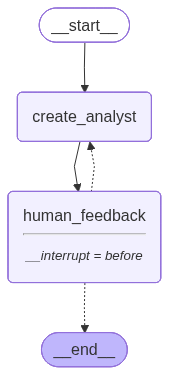

In [25]:
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
graph

In [26]:
topic = "The benefits of adopting langgraph as an Agent Framework for building AI applications."
max_analysts = 4
thread = {"configurable": {"thread_id": "1"}}


In [27]:
for event in graph.stream({"topic": topic, 
             "max_analysts": max_analysts}, 
             thread,
             stream_mode = "values"):
    analysts = event.get("analysts",'')

    if analysts:
        for analyst in analysts:
            print(analyst.persona)

Name: Alice Thompson
Role: AI Application Architect
Affiliation: TechForward Solutions
Description: Focuses on the practical implementation of AI frameworks. Concerned with ease of integration, scalability, and maintainability of applications built with LangGraph.

Name: Bob Chen
Role: AI Research Scientist
Affiliation: Global AI Institute
Description: Interested in the theoretical advantages of LangGraph. Explores its capabilities in handling complex agent interactions, memory management, and long-term planning.

Name: Charlie Davis
Role: AI Ethics and Governance Officer
Affiliation: Ethical AI Consortium
Description: Prioritizes the ethical implications of using LangGraph. Examines its potential for bias, transparency, and alignment with AI safety principles in autonomous agent systems.

Name: Diana Rodriguez
Role: AI Product Manager
Affiliation: InnovAI Corp
Description: Evaluates LangGraph from a product perspective. Focuses on its potential to accelerate development cycles, improv

In [28]:
state = graph.get_state(thread)
state

StateSnapshot(values={'topic': 'The benefits of adopting langgraph as an Agent Framework for building AI applications.', 'max_analysts': 4, 'analysts': [Analyst(name='Alice Thompson', role='AI Application Architect', affiliation='TechForward Solutions', description='Focuses on the practical implementation of AI frameworks. Concerned with ease of integration, scalability, and maintainability of applications built with LangGraph.'), Analyst(name='Bob Chen', role='AI Research Scientist', affiliation='Global AI Institute', description='Interested in the theoretical advantages of LangGraph. Explores its capabilities in handling complex agent interactions, memory management, and long-term planning.'), Analyst(name='Charlie Davis', role='AI Ethics and Governance Officer', affiliation='Ethical AI Consortium', description='Prioritizes the ethical implications of using LangGraph. Examines its potential for bias, transparency, and alignment with AI safety principles in autonomous agent systems.')

StateSnapshot(values={'topic': 'The benefits of adopting langgraph as an Agent Framework for building AI applications.', 'max_analysts': 4, 'analysts': [Analyst(name='Alice Thompson', role='AI Application Architect', affiliation='TechForward Solutions', description='Focuses on the practical implementation of AI frameworks. Concerned with ease of integration, scalability, and maintainability of applications built with LangGraph.'), Analyst(name='Bob Chen', role='AI Research Scientist', affiliation='Global AI Institute', description='Interested in the theoretical advantages of LangGraph. Explores its capabilities in handling complex agent interactions, memory management, and long-term planning.'), Analyst(name='Charlie Davis', role='AI Ethics and Governance Officer', affiliation='Ethical AI Consortium', description='Prioritizes the ethical implications of using LangGraph. Examines its potential for bias, transparency, and alignment with AI safety principles in autonomous agent systems.'), Analyst(name='Diana Rodriguez', role='AI Product Manager', affiliation='InnovAI Corp', description='Evaluates LangGraph from a product perspective. Focuses on its potential to accelerate development cycles, improve application performance, and deliver innovative AI-powered solutions to market.')]}, next=('human_feedback',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0dd2af-a749-695b-8001-c869f558b710'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-12-19T22:35:10.878560+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0dd2af-8157-6caa-8000-43e00f3bcf28'}}, tasks=(PregelTask(id='920cf0c6-ef10-41da-7d44-20642e35c68e', name='human_feedback', path=('__pregel_pull', 'human_feedback'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [29]:
state.next

('human_feedback',)

In [30]:
graph.update_state(thread, 
                   {"human_analyst_feedback": "Please focus more on practical applications and have startup perspectives."},
                   as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0df8fa-3971-6fcf-8002-669997478c83'}}

In [31]:
for event in graph.stream({"topic": topic, 
             "max_analysts": max_analysts}, 
             thread,
             stream_mode = "values"):
    analysts = event.get("analysts",'')

    if analysts:
        for analyst in analysts:
            print(analyst.persona)

Name: Alice Thompson
Role: AI Application Architect
Affiliation: TechForward Solutions
Description: Focuses on the practical implementation of AI frameworks. Concerned with ease of integration, scalability, and maintainability of applications built with LangGraph.

Name: Bob Chen
Role: AI Research Scientist
Affiliation: Global AI Institute
Description: Interested in the theoretical advantages of LangGraph. Explores its capabilities in handling complex agent interactions, memory management, and long-term planning.

Name: Charlie Davis
Role: AI Ethics and Governance Officer
Affiliation: Ethical AI Consortium
Description: Prioritizes the ethical implications of using LangGraph. Examines its potential for bias, transparency, and alignment with AI safety principles in autonomous agent systems.

Name: Diana Rodriguez
Role: AI Product Manager
Affiliation: InnovAI Corp
Description: Evaluates LangGraph from a product perspective. Focuses on its potential to accelerate development cycles, improv

In [32]:
state = graph.get_state(thread)
state

StateSnapshot(values={'topic': 'The benefits of adopting langgraph as an Agent Framework for building AI applications.', 'max_analysts': 4, 'human_analyst_feedback': 'Please focus more on practical applications and have startup perspectives.', 'analysts': [Analyst(name='Ava Chen', role='Lead AI Engineer', affiliation='Startup X', description='Focuses on the practical implementation of LangGraph for building scalable and reliable AI applications within a fast-paced startup environment. Concerned with minimizing development time and maximizing resource efficiency.'), Analyst(name='Ben Carter', role='CTO', affiliation='AI Startup Y', description="Interested in LangGraph's potential to streamline agent development and improve the overall architecture of AI-powered products. Motivated by the need to quickly iterate and adapt to changing market demands while maintaining a competitive edge."), Analyst(name='Chloe Davis', role='AI Product Manager', affiliation='Emerging AI Company Z', descript

StateSnapshot(values={'topic': 'The benefits of adopting langgraph as an Agent Framework for building AI applications.', 'max_analysts': 4, 'human_analyst_feedback': 'Please focus more on practical applications and have startup perspectives.', 'analysts': [Analyst(name='Alice Thompson', role='AI Application Architect', affiliation='TechForward Solutions', description='Focuses on the practical implementation of AI frameworks. Concerned with ease of integration, scalability, and maintainability of applications built with LangGraph.'), Analyst(name='Bob Chen', role='AI Research Scientist', affiliation='Global AI Institute', description='Interested in the theoretical advantages of LangGraph. Explores its capabilities in handling complex agent interactions, memory management, and long-term planning.'), Analyst(name='Charlie Davis', role='AI Ethics and Governance Officer', affiliation='Ethical AI Consortium', description='Prioritizes the ethical implications of using LangGraph. Examines its potential for bias, transparency, and alignment with AI safety principles in autonomous agent systems.'), Analyst(name='Diana Rodriguez', role='AI Product Manager', affiliation='InnovAI Corp', description='Evaluates LangGraph from a product perspective. Focuses on its potential to accelerate development cycles, improve application performance, and deliver innovative AI-powered solutions to market.')]}, next=('create_analyst',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0dd2bc-ca36-6643-8002-d74ca18ed1e7'}}, metadata={'source': 'update', 'step': 2, 'parents': {}}, created_at='2025-12-19T22:41:03.507821+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0dd2af-a749-695b-8001-c869f558b710'}}, tasks=(PregelTask(id='b75dbd97-3fef-8e98-2745-855ec720589a', name='create_analyst', path=('__pregel_pull', 'create_analyst'), error=None, interrupts=(), state=None, result=None),), interrupts=())

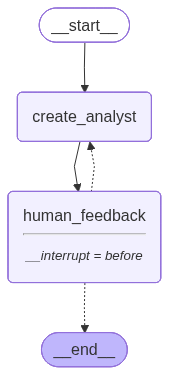

In [33]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

# Second Workflow

In [34]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [35]:
import os
from dotenv import load_dotenv
load_dotenv()
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

In [36]:
tavily_search = TavilySearchResults(tavily_api_key=TAVILY_API_KEY)
tavily_search.invoke("Medium Articles on creating Underwriting AI Assistants")

C:\Users\ARSHPARAM\AppData\Local\Temp\ipykernel_2928\3371133360.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(tavily_api_key=TAVILY_API_KEY)


[{'title': 'AI Assistants In Underwriting: Enhancing Precision And Speed',
  'url': 'https://worthai.com/blog/ai-assistants-in-underwriting-enhancing-precision-and-speed/',
  'content': 'AI underwriting assistants are sophisticated tools designed to augment the capabilities of human underwriters. These AI systems leverage machine learning algorithms and vast datasets to evaluate risk factors, process applications, and make informed decisions. They can quickly analyze large volumes of data, identify patterns, and provide insights that would be challenging for humans to discern manually.\n\nAI is Not Here to Take Jobs but to Improve Decision-Making and Accuracy [...] AI underwriting assistants are not just a technological advancement; they are a strategic asset that can significantly enhance your underwriting processes. By leveraging data-driven insights and automating repetitive tasks, AI assistants enable financial institutions to make better decisions and improve efficiency. Take the 

In [69]:
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.utilities import WikipediaAPIWrapper
docs = WikipediaLoader(query="The Benefits of adopting LangGraph as an Agent Framework").load()
print(docs[0].page_content[:500])

The Semantic Web, sometimes known as Web 3.0, is an extension of the World Wide Web through standards set by the World Wide Web Consortium (W3C). The goal of the Semantic Web is to make Internet data machine-readable.
To enable the encoding of semantics with the data, technologies such as Resource Description Framework (RDF) and Web Ontology Language (OWL) are used. These technologies are used to formally represent metadata. For example, ontology can describe concepts, relationships between enti


In [72]:
wiki = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=400)
docs = wiki.run("The Benefits of adopting LangGraph as an Agentic Framework.")
print(docs)

Page: Semantic Web
Summary: The Semantic Web, sometimes known as Web 3.0, is an extension of the World Wide Web through standards set by the World Wide Web Consortium (W3C). The goal of the Semantic Web is to make Internet data machine-readable.
To enable the encoding of semantics with the data, technologies such as Resource Description Framework (RDF) and Web Ontology Language (OWL) are used. The


In [38]:
from typing import Annotated
import operator
from langgraph.graph import MessagesState
from langchain_core.messages import get_buffer_string

class InterviewState(MessagesState):
    max_num_turns:int # number of turns in conversation
    context:Annotated[list, operator.add] # Source documents
    analyst: Analyst # Analyst asking questions
    interview:str # Full interview transcript
    sections:list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval")

In [39]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

In [40]:
print(analyst.persona)

Name: David Evans
Role: AI Research Scientist
Affiliation: Stealth AI Startup A
Description: Explores the advanced capabilities of LangGraph for building complex AI agents and its potential to unlock new possibilities in AI-driven innovation. Driven by a desire to push the boundaries of what's possible with AI and create groundbreaking solutions.



In [41]:
question_instructions.format(goals =analyst.persona)

'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: David Evans\nRole: AI Research Scientist\nAffiliation: Stealth AI Startup A\nDescription: Explores the advanced capabilities of LangGraph for building complex AI agents and its potential to unlock new possibilities in AI-driven innovation. Driven by a desire to push the boundaries of what\'s possible with AI and create groundbreaking solutions.\n\n\nBegin by introducing yourself using a name that fits your persona, and then ask your question.\n\nContinue to ask questions to drill down and refine your understanding of the topic.\n\nWhen you are satisfied with your understanding, complete the

'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: David Lee\nRole: Venture Capitalist\nAffiliation: Future Ventures\nDescription: Evaluates the potential of LangGraph to create new investment opportunities in the AI space. Focuses on the long-term viability and market potential of companies using LangGraph to build innovative AI solutions. Motivated by identifying and supporting the next generation of AI-driven startups.\n\n\nBegin by introducing yourself using a name that fits your persona, and then ask your question.\n\nContinue to ask questions to drill down and refine your understanding of the topic.\n\nWhen you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"\n\nRemember to stay in character throughout your response, reflecting the persona and goals provided to you.

In [42]:
def generation_question(state:InterviewState):
    """Node to generate the questions"""
    
    #get state
    analyst = state["analyst"]
    messages = state["messages"]
    
    #generate the question
    system_message = question_instructions.format(goals = analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
    
    #return the question through state
    return {"messages":[question]}


In [43]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],
         'messages': [HumanMessage(content="Hi do the proper search according to the experties", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [44]:
result = generation_question(state)
print(result['messages'])

[AIMessage(content="Okay, here we go.\n\nHi David, my name is Anya Sharma, and I'm an analyst focusing on the practical applications of cutting-edge AI technologies. I'm particularly interested in LangGraph and its potential for building more sophisticated AI agents. Given your work at Stealth AI Startup A, I was hoping you could share some insights.\n\nTo start, what's the most *interesting* or *non-obvious* advantage LangGraph offers over traditional approaches to building AI agents, in your experience? I'm not looking for textbook definitions, but rather something you've discovered in your own work.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--8c3f3551-374c-4e9d-a296-d33796283fd9-0', usage_metadata={'input_tokens': 234, 'output_tokens': 127, 'total_tokens': 361, 'input_token_details': {'cache_read': 0}})]


In [45]:
# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation. 
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query""")

In [46]:
def search_web(state:InterviewState):
    """
    Retrieve data from the web
    """
    structure_llm = llm.with_structured_output(SearchQuery)
    search_query = structure_llm.invoke([search_instructions]+state["messages"])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)
    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [47]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

result = search_web(state)

In [48]:
print(result["context"][0])

<Document href="https://www.metacto.com/blogs/a-developer-s-guide-to-langgraph-building-stateful-controllable-llm-applications"/>
LangGraph is a stateful, orchestration framework designed to build powerful and controllable LLM applications. It provides the essential building blocks for creating agentic systems that are reliable, customizable, and ready for production. Whether you are experimenting with multi-agent workflows or building a complex task automation tool, LangGraph offers a flexible foundation. [...] At its core, LangGraph is a controllable cognitive architecture for any task. It is a library built to help developers create agentic and multi-agent applications with LLMs, by modeling workflows as a graph. This graph-based approach allows for cyclical processes, giving developers explicit control over the flow of logic. This is a significant departure from the more linear, directed acyclic graphs (DAGs) often found in other data orchestration frameworks. [...] LangGraph repre

In [49]:
def search_wikipedia(state:InterviewState):
    """
    Retrieve data from wiki
    """
    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    print("*******************************")
    print(search_query)
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

In [50]:
result = search_wikipedia(state)

*******************************
search_query='Langgraph framework for business innovation'


In [51]:
result

{'context': ['']}

In [52]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [53]:
def generate_answer(state:InterviewState):
   
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

In [54]:
def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    
    return "ask_question"

# %%
def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

# %%
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

# %%
def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}


In [55]:
interview_builder = StateGraph(InterviewState)

In [56]:
interview_builder.add_node("ask_question", generation_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("generate_answer", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

In [57]:
interview_builder.add_edge(START,"ask_question")
interview_builder.add_edge("ask_question","search_web")
interview_builder.add_edge("ask_question","search_wikipedia")
interview_builder.add_edge("search_web","generate_answer")          
interview_builder.add_edge("search_wikipedia","generate_answer")

interview_builder.add_conditional_edges("generate_answer",
                                        route_messages, 
                                        ["ask_question",
                                         "save_interview"])

interview_builder.add_edge("save_interview","write_section")
interview_builder.add_edge("write_section", END)    

In [58]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run = "Conduct Interview")


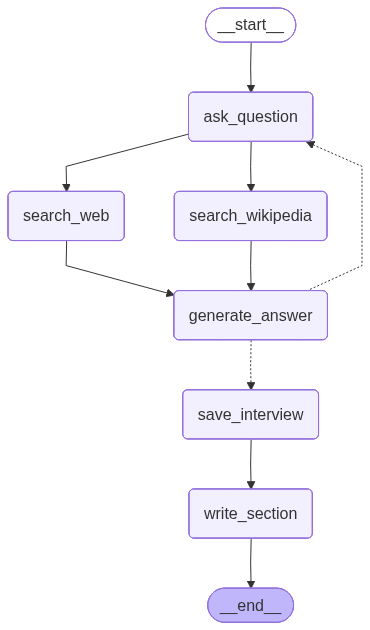

In [59]:
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [61]:
analyst

Analyst(name='David Evans', role='AI Research Scientist', affiliation='Stealth AI Startup A', description="Explores the advanced capabilities of LangGraph for building complex AI agents and its potential to unlock new possibilities in AI-driven innovation. Driven by a desire to push the boundaries of what's possible with AI and create groundbreaking solutions.")

In [62]:
messages = [HumanMessage("Hi do the proper search on creating Underwriting AI Assistant")]
thread = {"configurable": {"thread_id": "interview_1"}}

In [64]:
interview = interview_graph.invoke({"analyst": analyst,
                                    "messages": messages,
                                    "max_num_turns": 2
                                    }, thread)

*******************************
search_query='LangGraph vs traditional chained-prompt approach underwriting AI assistant'
*******************************
search_query='LangGraph vs traditional chained-prompt approach underwriting AI assistant'


In [65]:
Markdown(interview["sections"][0])

## LangGraph: Architecting the Future of AI Agent Workflows

### Summary

LangGraph, an open-source framework developed by the LangChain team, is designed to facilitate the creation of more intelligent and adaptable AI agent workflows. Unlike LangChain, which excels at linear, sequential tasks, LangGraph employs a graph-based architecture where tasks are represented as nodes and their connections as edges [2]. This structure enables the creation of complex workflows that can branch, loop, maintain state, and handle intricate scenarios, making it particularly suitable for applications like sophisticated customer support agents, multi-agent collaboration, and virtual assistants [2, 4, 5].

The key advantage of LangGraph lies in its ability to manage complex, stateful AI agents, offering features such as checkpointing and native support for streaming, which enhance user experience and system reliability [4]. For instance, LangGraph can be used to build an AI assistant that manages a complex booking process or a team of agents working together to write and debug code [4]. It facilitates dynamic decision-making, loops, and even human intervention within the workflow [4]. LangGraph's architecture allows for looping back to previous steps, retrying failed steps, and managing alternative paths, eliminating the need for ad-hoc workarounds [2].

While LangChain is suitable for rapidly prototyping linear workflows, LangGraph is the preferred choice for engineering teams focused on building complex AI agents from the ground up, especially when the project demands significant resources and long-term commitment [4]. An example of LangGraph's capability is the creation of an intelligent email responder that extracts intent, generates structured outlines, drafts email bodies, and refines the tone of the response [5]. This multi-step workflow demonstrates LangGraph's ability to decompose complex tasks into manageable, reliable steps through prompt chaining [5].

### Sources
[1] https://medium.com/@tahirbalarabe2/%EF%B8%8Flangchain-vs-langgraph-a-comparative-analysis-ce7749a80d9c
[2] https://www.truefoundry.com/blog/langchain-vs-langgraph
[3] https://oxylabs.io/blog/langgraph-vs-langchain
[4] https://www.eesel.ai/blog/langchain-vs-langgraph
[5] https://aamernabi.github.io/posts/prompt-chaining-using-langgraph/

## Third Workflow

In [77]:
from typing_extensions import TypedDict
from typing import List, Annotated
import operator
class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

In [78]:
from langgraph.types import Send

In [79]:
def initiate_all_interviews(state:ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """ 
    
    #check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"
    
    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                        "messages": [HumanMessage(
                                            content=f"So you said you were writing an article on {topic}?"
                                        )
                                                ]}) for analyst in state["analysts"]]


In [80]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""


report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

In [81]:
def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}


def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}



# %%
def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

# %%
def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}


In [82]:
# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analyst)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

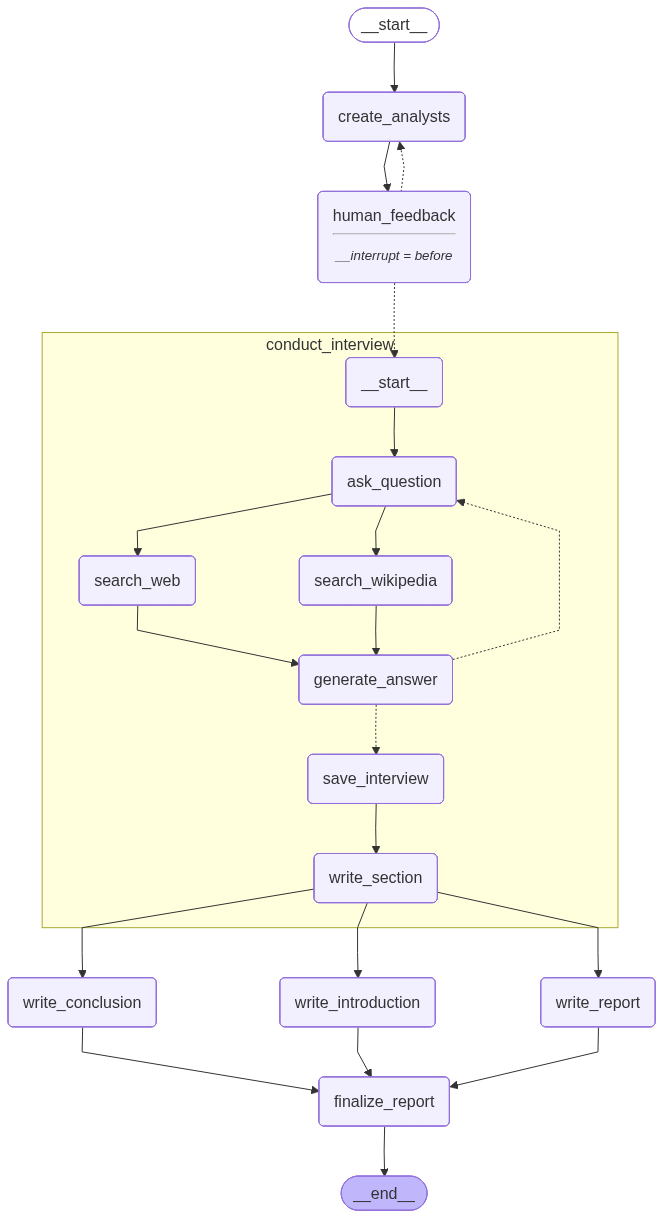

In [ ]:
memory = MemorySaver()

graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [84]:
max_analysts = 3

topic = "How can generative help us to play the cricket?"


# topic = "How can generative AI accelerate drug discovery?"

# %%
thread = {"configurable": {"thread_id": "1"}}

# %%
# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

# %%
graph.update_state(thread, {"human_analyst_feedback":"along with the genetive ai in future tell me the future of indian team"}, as_node="human_feedback")

# %%
# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 



Name: Data Dynamics
Affiliation: Sports Analytics Corp
Role: Data Analyst
Description: Focuses on how generative AI can enhance cricket strategy through data analysis, predicting player performance, and optimizing team compositions.
--------------------------------------------------
Name: Tech Innovator
Affiliation: Future Sports Institute
Role: Technology Consultant
Description: Explores the technological advancements generative AI brings to cricket, such as creating personalized training programs, improving broadcasting quality, and developing new fan engagement methods.
--------------------------------------------------
Name: Fair Play Advocate
Affiliation: Global Sports Ethics Council
Role: Ethics Advisor
Description: Addresses the ethical considerations of using generative AI in cricket, ensuring fair competition, preventing bias in algorithms, and maintaining the integrity of the sport.
--------------------------------------------------
Name: Data Dynamics
Affiliation: Sports Ana

In [85]:

graph.update_state(thread, {"human_analyst_feedback":""}, as_node="human_feedback")

# %%
graph.get_state(thread).next



('conduct_interview', 'conduct_interview', 'conduct_interview')

In [86]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

*******************************
search_query='generative AI applications in cricket'
*******************************
search_query='ethical implications of using generative AI in cricket to assist players or teams'
*******************************
search_query='generative AI applications in cricket beyond commentary and highlight reels'
*******************************
search_query='ethical implications of generative AI in cricket player assistance'
*******************************
search_query='generative AI applications in cricket beyond commentary and highlight reels'
--Node--
conduct_interview
--Node--
conduct_interview
*******************************
search_query='How can generative AI improve cricket player performance, team strategy, fan engagement, and talent scouting?'


Gemini produced an empty response. Continuing with empty message
Feedback: 


--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


In [87]:
final_state = graph.get_state(thread)
final_state 

StateSnapshot(values={'topic': 'How can generative help us to play the cricket?', 'max_analysts': 3, 'human_analyst_feedback': '', 'analysts': [Analyst(name='Data-Driven Dave', role='AI Strategist', affiliation='Cricket Analytics Inc.', description='Focuses on how generative AI can optimize player performance and team strategy through data analysis and predictive modeling. Concerned with ensuring data accuracy and ethical use of AI in cricket.'), Analyst(name='Future Forward Fatima', role='Technology Foresight Analyst', affiliation='Sports Tech Innovations', description='Specializes in predicting the future impact of generative AI on cricket, particularly for the Indian team. Motivated by exploring new possibilities and ensuring the team stays ahead of the curve with cutting-edge technology.'), Analyst(name='Ethical Ed', role='AI Ethics Advisor', affiliation='Fair Play Foundation', description='Dedicated to addressing the ethical implications of using generative AI in cricket. Focuses 

In [88]:
# %%
report = final_state.values.get('final_report')

# %%
Markdown(report)


# Generative AI: A New Innings for Cricket

## Introduction

This report explores how generative AI is revolutionizing cricket, impacting everything from player performance to fan engagement and ethical considerations. We begin by examining how AI provides data-driven insights for optimizing player skills, team strategy, and talent scouting, moving beyond traditional methods. Next, we focus on the Indian team, illustrating how AI can enhance strategic analysis, personalize player development, and enrich the fan experience through real-time highlights and interactive replays. Finally, we address the ethical dimensions of AI in cricket, emphasizing the importance of fairness, transparency, and mitigating biases to maintain the integrity of the sport.

---



Generative AI is revolutionizing cricket across multiple dimensions, from enhancing player performance and strategic decision-making to transforming fan engagement and ensuring fair play. This technological shift involves leveraging vast datasets, including game footage, performance metrics, and biometric data, to provide comprehensive insights into player capabilities and game dynamics [1, 15]. The traditional reliance on intuition is giving way to data-driven strategies, marking a significant evolution in the sport [6].

AI's applications in cricket are diverse and impactful. Personalized player development plans, AI-powered team selection, and predictive modeling for match simulations are becoming increasingly common [1, 16]. For example, the England women’s cricket team utilizes AI to simulate team lineups against various opponents, informing strategic team selection [16]. AI also streamlines talent scouting by efficiently processing extensive datasets to identify potential star players [1, 15]. Furthermore, AI-driven systems enhance umpiring accuracy by analyzing ball movements from multiple angles, aiding in close calls [3, 5]. Tools like CLEAR® AI and iCricket automate live analysis, generate personalized highlights, and offer AI-driven coaching [1, 2]. Imagine an AI that provides personalized training plans based on a player's weaknesses identified in their last match [2].

Fan engagement is also being transformed through personalized highlights and interactive replays [3, 6]. Platforms like Magnifi automatically generate and distribute real-time, AI-curated highlights, ensuring fans don't miss key moments [3, 6]. The International Cricket Council (ICC) is integrating AI into its digital platforms to create more engaging experiences, including alternative strategy replays and exploring different match outcomes [3].

However, the integration of AI also presents ethical challenges. Algorithmic biases, data privacy concerns, and the potential for over-reliance on AI must be addressed to maintain the integrity of the sport [2, 4, 6]. Algorithmic biases can arise from a lack of diversity in training data, leading to unfair outcomes [4, 6]. To mitigate these risks, it is essential to implement robust data security measures, obtain informed consent from players regarding data collection and usage, and ensure transparency and explainability in AI algorithms [4]. Balancing AI recommendations with human judgment and maintaining player autonomy are crucial to ensuring that AI serves as a tool to enhance decision-making, not replace strategic thinking [1, 2, 4].

As AI technology continues to evolve, its role in shaping the future of cricket will only grow [2, 17]. Embracing these technologies offers teams a competitive edge, enabling sustained success through data-driven strategies and enhanced player development.


---

## Conclusion

Generative AI is poised to revolutionize cricket, impacting player performance, strategy, and fan engagement. AI-driven analytics offer data-driven insights for optimizing player development and team selection, moving beyond traditional intuition. For teams like the Indian team, AI provides a competitive edge through real-time analysis and personalized coaching. However, ethical considerations are paramount. Addressing algorithmic biases, ensuring data privacy, and maintaining player autonomy are crucial for fair play. By thoughtfully integrating AI while upholding ethical standards, cricket can harness its transformative power while preserving the integrity of the sport.

## Sources

[1] https://otsi-global.com/generative-ai-analytics-for-a-state-cricket-association-case-studies/
[2] https://digitaldefynd.com/IQ/ai-use-in-cricket/
[3] https://www.linkedin.com/posts/aman-kumar-b4881440_aiinsports-llm-generativeai-activity-7363539861212913664-mdFY
[4] https://webosmotic.com/blog/ai-in-cricket/
[5] https://www.alteryx.com/blog/crickets-data-driven-revolution-analytics-alteryx-and-the-games-new-frontier
[6] https://www.linkedin.com/pulse/role-ai-cricket-revolutionizing-game-webosmotic-ugguf
[7] https://www.tiffin.edu/wp-content/uploads/Report-Future-of-AI-and-Sport.pdf
[8] https://masterofcode.com/blog/generative-ai-in-sports
[9] https://www.amu.apus.edu/area-of-study/health-sciences/resources/ai-in-sports/
[10] https://www.primefocustechnologies.com/blog-cms/clear-ai-reimagining-sports-storytelling
[11] https://aiblogfirst.com/ai-tools-for-cricket-analysis/
[12] https://www.capgemini.com/wp-content/uploads/2025/07/Final-Web-Version-Report-Tech-In-Sports.pdf
[13] https://magnifi.ai/insights/free-sports-highlights-software
[14] https://medium.com/@rakrag21/revolutionizing-cricket-the-impact-of-artificial-intelligence-on-the-sport-65fb797c043a
[15] https://www.ijnrd.org/papers/IJNRD2311209.pdf
[16] https://www.linkedin.com/posts/rohitpandharkar_generativeai-activity-7385522583326121984-bc3x
[17] https://www.ijfmr.com/papers/2024/4/25324.pdf
[18] https://news.microsoft.com/source/asia/features/from-grassroots-to-elite-how-cricket-australia-is-scoring-better-digital-experiences-with-ai-and-cloud-technology/
[19] https://actaint.com/index.php/pub/article/view/275